In [76]:
import numpy as np
from collections import OrderedDict as odict
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [94]:
arch = {'knl':(cm.Greens, 450,0.5,0.33),'skl':(cm.Greys,200,0.5,0.75),   'p100':(cm.Blues,  550,0.5,0.43),
       'v100':(cm.Purples,850,0.5,0.85), 'i5':(cm.Wistia,30,0.5,0.79),'gtx1060':(cm.Oranges,155,0.5,0.70)}
intens={1:0.8, 2:0.6, 4:0.4}
marker={2:'d', 3:'o', 4:'s',5:'p'}
#(hardware name, number of nodes)
filesD = {
         'knl_mpi1':('knl',1), 'knl_mpi2':('knl',2), 'knl_mpi4':('knl',4),
         'skl_mpi1':('skl',1), 'skl_mpi2':('skl',2), 'skl_mpi4':('skl',4),
         'i5':('i5',1),
         'p100_mpi1':('p100',1), 'p100_mpi2':('p100',2), 'p100_mpi4':('p100',4),
         'v100_mpi1':('v100',1), 'v100_mpi2':('v100',2), 'v100_mpi4':('v100',4),
         'gtx1060':('gtx1060',1)
        }

files = odict(sorted(filesD.items(), key= lambda t : t[1][1]))
number=0
for k,v in files.items(): 
    if v[1]==1: number+=1
pd.set_option('precision',1)

In [182]:
#(axpby,dot,dxdy)
latencies = odict()
latencies['scal'] = (1,0,0)
latencies['axpby'] = (1,0,0)
latencies['pointwiseDot'] = (1,0,0)
latencies['dot'] = (0,1,0)
latencies['dx'] = (0,0,1)
latencies['dy'] = (0,0,1)
latencies['arakawa'] = (3,0,6)
latencies['cg'] = (6,2,6)
memops = odict()
memops['scal']= (2,0,0)
memops['axpby']= (3,0,0)
memops['pointwiseDot']= (6,0,0)
memops['dot']= (0,2,0)
memops['dx']= (0,0,3)
memops['dy']= (0,0,3)
memops['arakawa'] = (16,0,18) # two aliases in pointwiseDot
memops['cg'] = (20,4,18)

In [188]:
theo = pd.read_csv('performance.csv',delimiter=' ')
theo.set_index('arch',inplace=True)
theo.index.name = None
theo.loc['p100','dxdy_lat_dist'] = 1*theo.loc['p100','dxdy_lat_dist']
theo.loc['v100','dxdy_lat_dist'] = 1*theo.loc['v100','dxdy_lat_dist']
theo.loc['knl','dxdy_bw'] = theo.loc['knl','dxdy_bw']

theo

,axpby_bw,axpby_lat_shared,axpby_lat_dist,dot_bw,dot_lat_shared,dot_lat_dist,dxdy_bw,dxdy_lat_shared,dxdy_lat_dist
i5,30.0,12.4,NaN,9.3,117.4,NaN,27.3,69.8,NaN
skl,206.8,6.1,6.9,193.6,24.5,32.6,123.2,50.6,60.5
knl,447.0,14.4,14.9,143.3,67.3,93.9,134.8,84.3,139.2
gtx1060,157.0,3.5,NaN,26.5,131.6,NaN,97.5,34.5,NaN
v100,848.3,3.1,3.1,591.6,41.5,48.2,681.1,7.8,452.2
p100,552.8,3.1,3.3,345.8,56.4,56.1,218.7,15.7,473.1


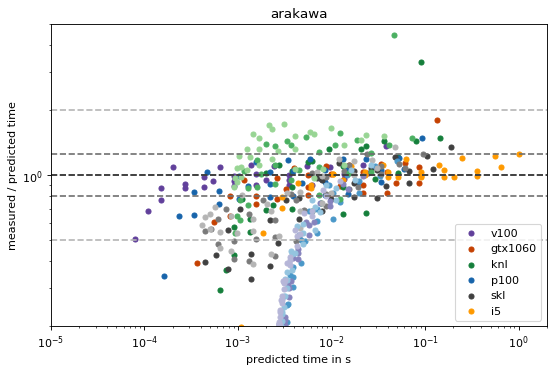

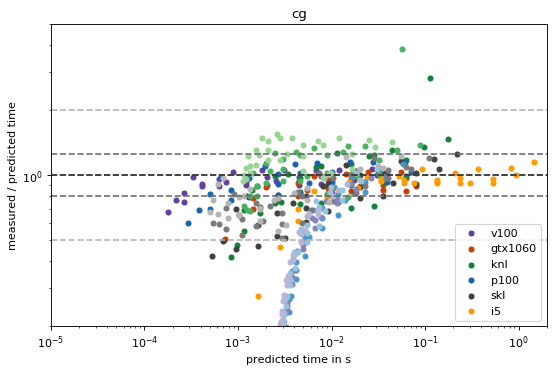

In [194]:

for n in ['arakawa','cg']:# latencies.keys():
    fig,ax=plt.subplots(1,1,figsize=(8,5),dpi= 80, facecolor='w', edgecolor='k')
    for frac in [1.0,5/4,8/4]:
        plt.plot(xs,frac*ys,ls='--',color=cm.Greys(0.8/frac))
        plt.plot(xs,1/frac*ys,ls='--',color=cm.Greys(0.8/frac))
    for f, v in files.items() :#{'knl_mpi2':('knl',2)}.items():
        string = '_shared'
        if v[1] > 1 : string = '_dist'
        df=pd.read_csv('benchmark_'+f+'.csv', delimiter=' ')
        #add size and get rid of non-relevant columns
        df.insert(0,'size', 8*df['n']*df['n']*df['Nx']*df['Ny']/1e6/v[1])
        dfr = df[['n','Nx','Ny','size']+list(memops.keys())]
        #compute mean and standard derivation of 'same' groups 
        dfr=dfr.groupby(['n', 'Nx','Ny','size']).mean()
        dfr=dfr.reset_index(level=['n','Nx','Ny','size'])

        dfr['FirstLevel']='measured'
        dfr.columns=pd.MultiIndex.from_product([dfr.columns,['measured']])
        del dfr['FirstLevel']

        for q,l in latencies.items():
            m = memops[q]
            dfr.loc[:,(q,'predicted')] = (( 
                                      l[0]*theo.loc[v[0],'axpby_lat'+string]
                                    + l[1]*theo.loc[v[0],'dot_lat'+string] 
                                    + l[2]*theo.loc[v[0],'dxdy_lat'+string])*1e-6
                                    + m[0]*dfr[('size','measured')]/1000/theo.loc[v[0],'axpby_bw']
                                    + m[1]*dfr[('size','measured')]/1000/theo.loc[v[0],'dot_bw']
                                    + m[2]*dfr[('size','measured')]/1000/theo.loc[v[0],'dxdy_bw'])
            dfr.loc[:,(q,'meas/pred')]=dfr[(q,'measured')]/dfr[(q,'predicted')]
        dfr.sort_values(by=('size','measured'),inplace=True)
        dfr[n].plot(kind='scatter',ax=ax,color=arch[v[0]][0](intens[v[1]]), #marker='o',ls='',
                      x='predicted',y='meas/pred',label=v[0])#,markersize=8)
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = handles[0:number]; labels = labels[0:number]
    xs = np.array([1e-5,2.0])
    ys = np.array([1.0,1.0])
    #plt.plot(xs,ys)

    
    plt.legend(handles, labels, loc='lower right',numpoints=1)
    plt.xscale('log')
    plt.xlim(xs[0],xs[1])
    plt.xlabel('predicted time in s')
    plt.ylabel('measured / predicted time')
    plt.yscale('log')
    plt.ylim(0.2,5)
    plt.title(n)

#### Conclusions
- black lines indicate factors 1, 1.25 and 2 respectively